In [1]:
!pip install evaluate
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import evaluate

2025-09-04 15:44:23.612490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757000663.958876      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757000664.055135      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
pss_data = pd.read_csv('/kaggle/input/train-set/2022-08-03-ss.processed.csv')
pss_data = pss_data.drop(columns=['sst3', 'has_nonstd_aa', 'len'])

# Display first few rows of the dataset
pss_data.head()

/tmp/ipykernel_36/3149027380.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  pss_data = pd.read_csv('/kaggle/input/train-set/2022-08-03-ss.processed.csv')


,pdb_id,chain_code,seq,sst8
0,1A30,C,EDL,CBC
1,1B05,B,KCK,CBC
2,1B0H,B,KAK,CBC
3,1B1H,B,KFK,CBC
4,1B32,B,KMK,CBC


In [4]:
# Remove any rows with missing 'sst8' values
pss_data_cleaned = pss_data.dropna(subset=['sst8'])

# Define the features and labels
X = pss_data_cleaned['seq']  # Amino acid sequence
y = pss_data_cleaned['sst8']  # Secondary structure labels (C, E, H, B, G, I, T, S)

# Split the dataset into training, validation, and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=0.5, random_state=42)

In [5]:
# Modify the model to use ESM2
model_name = "facebook/esm2_t30_150M_UR50D"  # ESM2 model

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors="pt"  # PyTorch tensors
    )

# Tokenize the datasets
train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
from datasets import Dataset
import torch

# Update label map for 8 states
label_map = {
    'C': 0, 'E': 1, 'H': 2,
    'B': 3, 'G': 4, 'I': 5,
    'T': 6, 'S': 7
}  # Update the labels for the 8 states

# Convert string labels (sequences) to a list of numeric labels for each residue and pad/truncate them
def prepare_labels(label_sequences, label_map, max_length, pad_value=-100):
    numeric_labels = []
    for seq in label_sequences:
        numeric_seq = [label_map.get(char, pad_value) for char in seq]  # Map 8 states
        truncated_seq = numeric_seq[:max_length]
        padded_seq = truncated_seq + [pad_value] * (max_length - len(truncated_seq))
        numeric_labels.append(padded_seq)
    return numeric_labels

# Get max_length from tokenization for each split
train_max_length = train_encodings["input_ids"].shape[1]
val_max_length = val_encodings["input_ids"].shape[1]
test_max_length = test_encodings["input_ids"].shape[1]

train_labels_numeric_padded = prepare_labels(train_labels, label_map, train_max_length)
val_labels_numeric_padded = prepare_labels(val_labels, label_map, val_max_length)
test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

# Convert the data into Hugging Face Dataset format with torch tensors
train_data = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"].clone().detach(),
    "attention_mask": train_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(train_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

val_data = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"].clone().detach(),
    "attention_mask": val_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(val_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

In [7]:
import torch
import torch.nn as nn
from transformers import AutoModelForTokenClassification

# Function to define the model and training arguments for Optuna optimization
class BiLSTMWithESM2(nn.Module):
    def __init__(self, transformer_model_name, lstm_hidden_dim, num_labels):
        super(BiLSTMWithESM2, self).__init__()

        # Load the transformer model (ESM2 in your case)
        self.transformer = AutoModelForTokenClassification.from_pretrained(transformer_model_name, num_labels=num_labels)

        # BiLSTM Layer
        self.lstm = nn.LSTM(
            input_size=self.transformer.config.hidden_size,  # ESM2 hidden size
            hidden_size=lstm_hidden_dim,  # Hidden size for the BiLSTM
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Final classification layer
        self.classifier = nn.Linear(lstm_hidden_dim * 2, num_labels)  # BiLSTM is bidirectional, so *2

    def forward(self, input_ids, attention_mask, labels=None):
        # Get the transformer outputs
        transformer_outputs = self.transformer(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract the last hidden states from transformer (output is (batch_size, seq_length, hidden_size))
        last_hidden_states = transformer_outputs.hidden_states[-1]

        # Pass the transformer outputs through the BiLSTM
        lstm_out, _ = self.lstm(last_hidden_states)

        # Use the output of the BiLSTM layer (last hidden state) for classification
        logits = self.classifier(lstm_out)

        # If labels are provided, compute the loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.transformer.config.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [8]:
# Initialize the model with BiLSTM and set hyperparameters
model = BiLSTMWithESM2(
    transformer_model_name="facebook/esm2_t30_150M_UR50D",  # ESM2 model
    lstm_hidden_dim=512,  # Size of LSTM hidden layer
    num_labels=8  # 8 classes (the updated secondary structure states)
)

# Function to define the model and training arguments
def create_model(params):
    model = BiLSTMWithESM2(
        transformer_model_name="facebook/esm2_t30_150M_UR50D",  # ESM2 model
        lstm_hidden_dim=512,  # Size of LSTM hidden layer
        num_labels=8  # 8 classes
    )

    # Training arguments with hyperparameters to tune
    training_args = TrainingArguments(
        output_dir=f"./esm2_token_output",  # Changed output directory name
        eval_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=32,
        num_train_epochs=params['epochs'],
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",  # Still using F1 as a metric
        greater_is_better=True,
        report_to="none",
    )
    return model, training_args

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Load evaluation metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")

# Updated compute_metrics function to calculate Q8 accuracy for 8 classes
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()

    mask = flat_labels != -100
    filtered_predictions = flat_predictions[mask]
    filtered_labels = flat_labels[mask]

    accuracy = accuracy_metric.compute(predictions=filtered_predictions, references=filtered_labels)
    precision = precision_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")
    recall = recall_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")
    f1 = f1_metric.compute(predictions=filtered_predictions, references=filtered_labels, average="weighted")

    # Q8 accuracy (percentage of correctly predicted residues out of 8 classes)
    q8_correct = sum(filtered_predictions == filtered_labels)  # Correct predictions across all 8 classes
    q8_accuracy = q8_correct / len(filtered_labels) if len(filtered_labels) > 0 else 0.0

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
        "q8_accuracy": q8_accuracy  # Return Q8 accuracy
    }

In [10]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./esm2_token_output",  # Output directory for model checkpoints
    eval_strategy="epoch",  # Evaluation strategy to be used
    learning_rate=5e-5,  # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=32,  # Batch size for evaluation
    num_train_epochs=5,  # Number of epochs
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir="./logs",  # Directory for logs
    logging_steps=10,  # Logging steps
    save_strategy="epoch",  # Save the model after every epoch
    load_best_model_at_end=True,  # Load the best model when finished
    metric_for_best_model="f1",  # Use F1 as the metric to monitor for best model
    greater_is_better=True,  # Higher F1 is better
    report_to="none",  # Disable reporting to other platforms (e.g., TensorBoard)
)

In [11]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

# Train the model
trainer.train()

/tmp/ipykernel_36/2853569088.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Q8 Accuracy
1,0.378500,0.383114,0.871080,0.868081,0.871080,0.868351,0.871080
2,0.319200,0.336314,0.886993,0.884282,0.886993,0.884822,0.886993
3,0.275100,0.314831,0.894614,0.892531,0.894614,0.892797,0.894614
4,0.244700,0.307845,0.898754,0.896973,0.898754,0.897302,0.898754
5,0.210000,0.312064,0.900900,0.899171,0.900900,0.899653,0.900900


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=27580, training_loss=0.3123362709855238, metrics={'train_runtime': 29068.0802, 'train_samples_per_second': 30.358, 'train_steps_per_second': 0.949, 'total_flos': 0.0, 'train_loss': 0.3123362709855238, 'epoch': 5.0})

In [12]:
# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Q8 Accuracy: 0.9016
Weighted F1 Score: 0.9004

Classification Report:
              precision    recall  f1-score   support

        Coil       0.90      0.89      0.90    646157
       Sheet       0.94      0.96      0.95    563979
       Helix       0.94      0.97      0.95    682331
        Beta       0.83      0.67      0.74     26516
       Gamma       0.80      0.79      0.79     72668
        Iota       0.74      0.38      0.50       381
        Turn       0.82      0.80      0.81    255238
      Strand       0.81      0.74      0.77    210849

    accuracy                           0.90   2458119
   macro avg       0.85      0.77      0.80   2458119
weighted avg       0.90      0.90      0.90   2458119



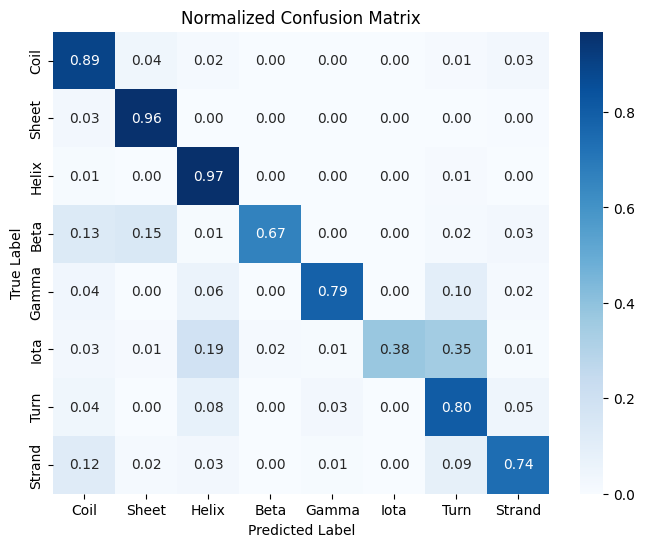

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with CASP12**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Q8 Accuracy: 0.7785
Weighted F1 Score: 0.7721

Classification Report:
              precision    recall  f1-score   support

        Coil       0.78      0.83      0.81       861
       Sheet       0.88      0.82      0.85       495
       Helix       0.82      0.91      0.87       623
        Beta       0.58      0.33      0.42        21
       Gamma       0.93      0.41      0.57        66
        Iota       0.00      0.00      0.00         5
        Turn       0.57      0.57      0.57       210
      Strand       0.53      0.43      0.48       197

    accuracy                           0.78      2478
   macro avg       0.64      0.54      0.57      2478
weighted avg       0.77      0.78      0.77      2478



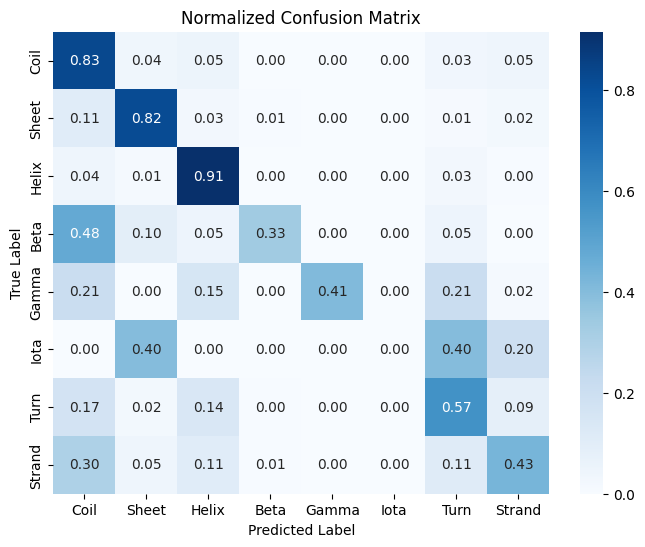

In [14]:
test = pd.read_csv('/kaggle/input/test-sets/CASP12.csv')
test_texts = test['input'].dropna().astype(str).tolist()
test_labels = test['dssp8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with CASP13**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Q8 Accuracy: 0.7829
Weighted F1 Score: 0.7750

Classification Report:
              precision    recall  f1-score   support

        Coil       0.77      0.69      0.73       355
       Sheet       0.79      0.94      0.86       305
       Helix       0.88      0.94      0.91       340
        Beta       0.57      0.57      0.57         7
       Gamma       0.81      0.32      0.46        41
        Iota       0.00      0.00      0.00         0
        Turn       0.69      0.69      0.69       121
      Strand       0.59      0.52      0.55       130

   micro avg       0.78      0.78      0.78      1299
   macro avg       0.64      0.58      0.60      1299
weighted avg       0.78      0.78      0.78      1299



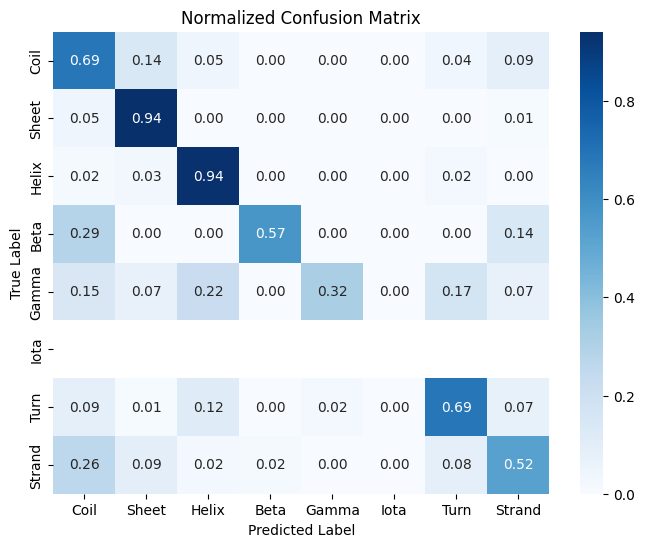

In [15]:
test = pd.read_csv('/kaggle/input/test-sets/CASP13.csv')
test_texts = test['input'].dropna().astype(str).tolist()
test_labels = test['dssp8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with CASP14**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Q8 Accuracy: 0.5900
Weighted F1 Score: 0.5889

Classification Report:
              precision    recall  f1-score   support

        Coil       0.60      0.58      0.59       629
       Sheet       0.49      0.73      0.59       352
       Helix       0.86      0.74      0.79       652
        Beta       0.15      0.06      0.09        32
       Gamma       0.41      0.22      0.29        55
        Iota       0.00      0.00      0.00         5
        Turn       0.33      0.33      0.33       205
      Strand       0.36      0.33      0.34       180

    accuracy                           0.59      2110
   macro avg       0.40      0.37      0.38      2110
weighted avg       0.60      0.59      0.59      2110



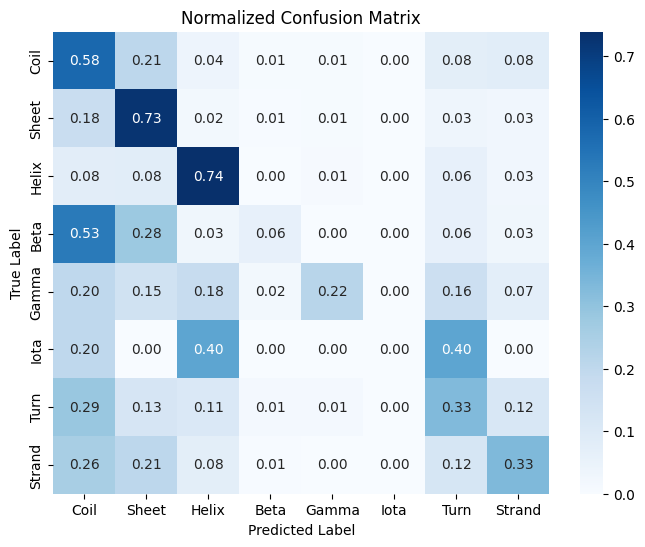

In [16]:
test = pd.read_csv('/kaggle/input/test-sets/CASP14.csv')
test_texts = test['input'].dropna().astype(str).tolist()
test_labels = test['dssp8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with CB513**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Q8 Accuracy: 0.8172
Weighted F1 Score: 0.8133

Classification Report:
              precision    recall  f1-score   support

        Coil       0.78      0.81      0.80    274416
       Sheet       0.87      0.89      0.88    218814
       Helix       0.90      0.92      0.91    326107
        Beta       0.60      0.41      0.49      8682
       Gamma       0.72      0.54      0.62     35336
        Iota       0.96      0.01      0.02      4218
        Turn       0.69      0.69      0.69    102848
      Strand       0.62      0.57      0.60     75446

    accuracy                           0.82   1045867
   macro avg       0.77      0.61      0.62   1045867
weighted avg       0.81      0.82      0.81   1045867



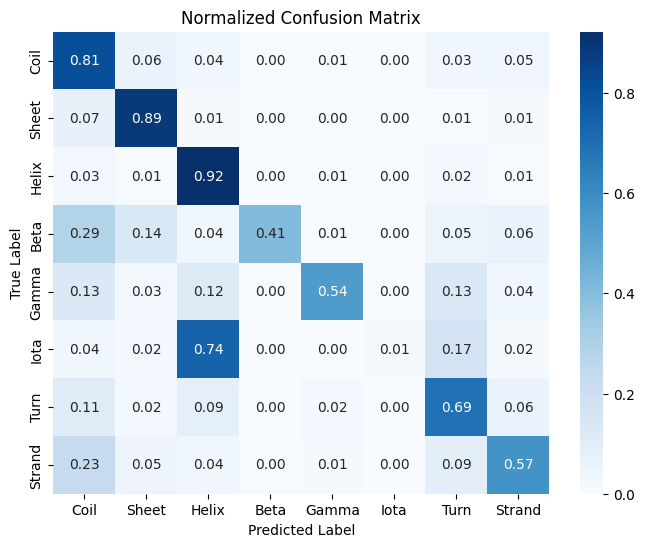

In [17]:
test = pd.read_csv('/kaggle/input/test-sets/CB513_training_secondary_structure_train.csv')
test_texts = test['seq'].dropna().astype(str).tolist()
test_labels = test['sst8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with PDB-Intersect-PISCES-2018-Test**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Q8 Accuracy: 0.8319
Weighted F1 Score: 0.8299

Classification Report:
              precision    recall  f1-score   support

        Coil       0.79      0.83      0.81    273240
       Sheet       0.89      0.90      0.90    232922
       Helix       0.91      0.93      0.92    328611
        Beta       0.67      0.45      0.54      9967
       Gamma       0.74      0.57      0.64     37598
        Iota       0.91      0.29      0.44       110
        Turn       0.72      0.71      0.72    109097
      Strand       0.65      0.60      0.62     78476

    accuracy                           0.83   1070021
   macro avg       0.79      0.66      0.70   1070021
weighted avg       0.83      0.83      0.83   1070021



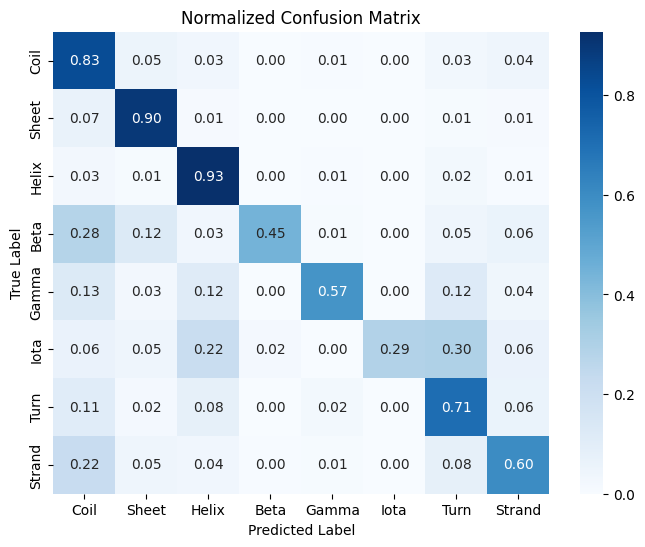

In [18]:
test = pd.read_csv('/kaggle/input/test-sets/PDB-Intersect-PISCES-2018-Test.csv')
test_texts = test['seq'].dropna().astype(str).tolist()
test_labels = test['sst8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with PDB-Intersect-PISCES-Pc30-R2.5-Test-2022**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Q8 Accuracy: 0.8203
Weighted F1 Score: 0.8180

Classification Report:
              precision    recall  f1-score   support

        Coil       0.78      0.82      0.80    960981
       Sheet       0.88      0.89      0.89    800224
       Helix       0.91      0.92      0.91   1144620
        Beta       0.64      0.41      0.50     33548
       Gamma       0.72      0.54      0.62    127101
        Iota       0.87      0.25      0.39       445
        Turn       0.70      0.69      0.69    370345
      Strand       0.62      0.57      0.60    271078

    accuracy                           0.82   3708342
   macro avg       0.76      0.64      0.67   3708342
weighted avg       0.82      0.82      0.82   3708342



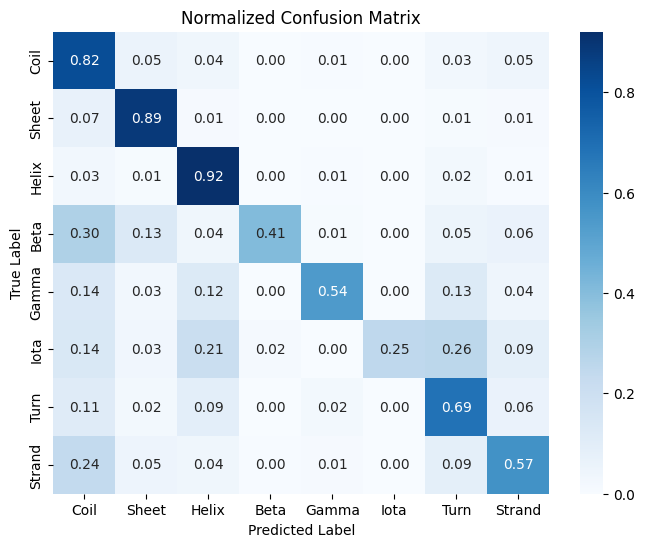

In [19]:
test = pd.read_csv('/kaggle/input/test-sets/PDB-Intersect-PISCES-Pc30-R2.5-Test-2022.csv')
test_texts = test['seq'].dropna().astype(str).tolist()
test_labels = test['sst8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with PS4**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Q8 Accuracy: 0.8016
Weighted F1 Score: 0.7971

Classification Report:
              precision    recall  f1-score   support

        Coil       0.68      0.79      0.73    402002
       Sheet       0.89      0.89      0.89    480762
       Helix       0.91      0.92      0.92    695047
        Beta       0.62      0.38      0.47     22087
       Gamma       0.69      0.52      0.59     70665
        Iota       0.93      0.01      0.01     10773
        Turn       0.69      0.67      0.68    235282
      Strand       0.64      0.54      0.59    197299

    accuracy                           0.80   2113917
   macro avg       0.76      0.59      0.61   2113917
weighted avg       0.80      0.80      0.80   2113917



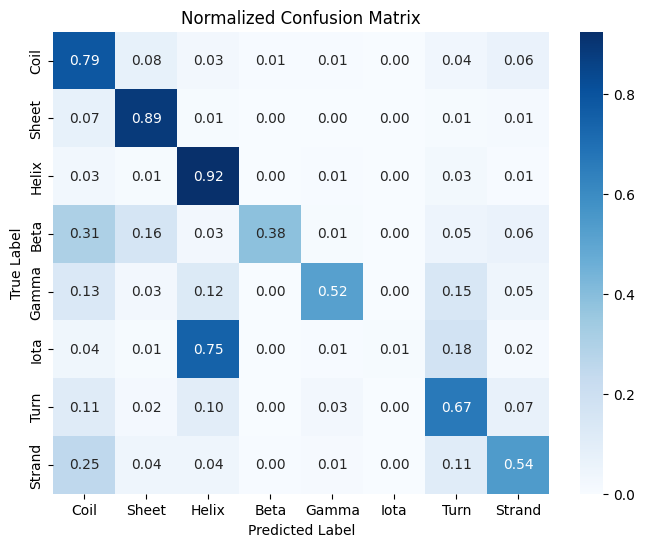

In [20]:
test = pd.read_csv('/kaggle/input/test-sets/PS4.csv')
test_texts = test['input'].dropna().astype(str).tolist()
test_labels = test['dssp8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with ProteinNet**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Q8 Accuracy: 0.7995
Weighted F1 Score: 0.8315

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Coil       0.00      0.00      0.00         0
       Sheet       0.94      0.87      0.91    892731
       Helix       0.93      0.92      0.92   1320353
        Beta       0.74      0.40      0.52     43952
       Gamma       0.72      0.50      0.59    136384
        Iota       0.86      0.11      0.20      1037
        Turn       0.74      0.65      0.69    448713
      Strand       0.75      0.54      0.63    364276

    accuracy                           0.80   3207446
   macro avg       0.71      0.50      0.56   3207446
weighted avg       0.87      0.80      0.83   3207446



/tmp/ipykernel_36/16474338.py:60: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


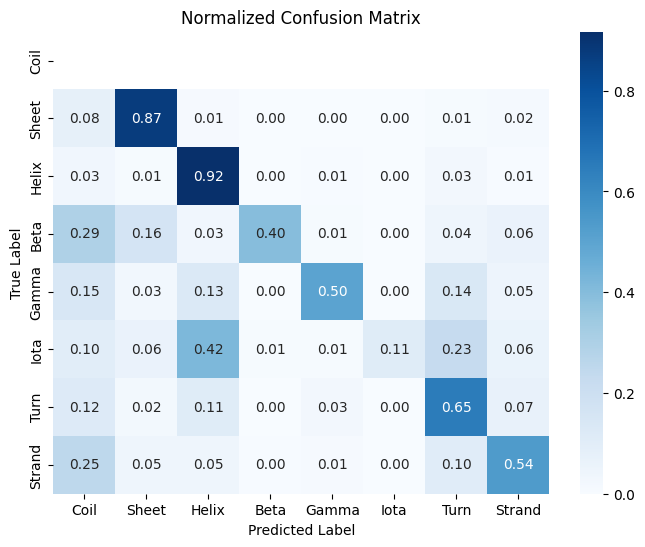

In [21]:
test = pd.read_csv('/kaggle/input/test-sets/ProteinNet_train.csv')
test_texts = test['seq'].dropna().astype(str).tolist()
test_labels = test['dssp8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()

**Test with TS115**

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Q8 Accuracy: 0.7842
Weighted F1 Score: 0.7788

Classification Report:
              precision    recall  f1-score   support

        Coil       0.75      0.79      0.77      3770
       Sheet       0.83      0.84      0.84      2358
       Helix       0.88      0.91      0.90      4783
        Beta       0.45      0.28      0.35       106
       Gamma       0.71      0.47      0.57       455
        Iota       0.00      0.00      0.00        60
        Turn       0.60      0.61      0.60      1201
      Strand       0.58      0.48      0.53      1005

    accuracy                           0.78     13738
   macro avg       0.60      0.55      0.57     13738
weighted avg       0.78      0.78      0.78     13738



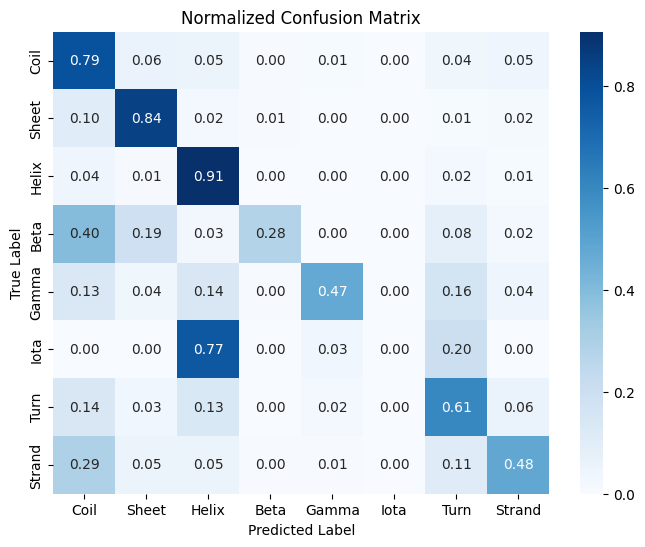

In [22]:
test = pd.read_csv('/kaggle/input/test-sets/test_secondary_structure_ts115.csv')
test_texts = test['seq'].dropna().astype(str).tolist()
test_labels = test['sst8'].dropna().astype(str).tolist()

test_encodings = tokenize_data(test_texts, tokenizer)

test_max_length = test_encodings["input_ids"].shape[1]

test_labels_numeric_padded = prepare_labels(test_labels, label_map, test_max_length)

test_data = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"].clone().detach(),
    "attention_mask": test_encodings["attention_mask"].clone().detach(),
    "labels": torch.tensor(test_labels_numeric_padded, dtype=torch.long) # Use the padded numeric labels
})

# Evaluate the model on the test data using the trainer's evaluate method
eval_results = trainer.evaluate(test_data)

# The eval_results dictionary contains the metrics calculated by compute_metrics, including Q3 accuracy and f1
q8_accuracy = eval_results["eval_q8_accuracy"]
f1_score = eval_results["eval_f1"]

# To get the classification report, we need the flattened, non-padded true and predicted labels from the test set
# We can get the predictions and labels using trainer.predict and then filter
predictions = trainer.predict(test_data)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Flatten and filter out padding (-100)
flat_predicted_labels = predicted_labels.flatten()
flat_true_labels = true_labels.flatten()

mask = flat_true_labels != -100
filtered_predicted_labels = flat_predicted_labels[mask]
filtered_true_labels = flat_true_labels[mask]

# Print Q3 accuracy and F1 score
print("Q8 Accuracy: {:.4f}".format(q8_accuracy))
print("Weighted F1 Score: {:.4f}".format(f1_score))

# Print classification report
# Define target names based on your label_map
target_names = ["Coil", "Sheet", "Helix", "Beta", "Gamma", "Iota", "Turn", "Strand"] # Assuming 0: Coil, 1: Sheet, 2: Helix, etc.
# Explicitly specify the labels to report on
report_labels = [0, 1, 2, 3, 4, 5, 6, 7] # Corresponding to the 8 states

print("\nClassification Report:")
print(classification_report(filtered_true_labels, filtered_predicted_labels, labels=report_labels, target_names=target_names))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy for normalization

# Generate the confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=report_labels)

# Normalize the confusion matrix by row (sum of each row is 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use fmt='.2f' for normalized values
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix') # Update title
plt.show()